## **DECISION TREE MODELS**

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
)
import matplotlib.pyplot as plt

In [38]:
## 1. Loading Data
df_train = pd.read_csv("train_features_fd001.csv")
df_test = pd.read_csv("test_features_fd001.csv")


In [39]:
## 2. SPLIT TRAINING AND TEST SET
y_train = df_train["fail_soon"].astype(int)
X_train = df_train.drop(["fail_soon", "id", "cycle", "RUL"], axis=1)
y_test = df_test["fail_soon"].astype(int)
X_test = df_test.drop(["fail_soon", "id", "cycle", "RUL"], axis=1)

groups = df_train["id"]

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in gss.split(X_train, y_train, groups=groups):
    X_train = X_train.iloc[train_idx].reset_index(drop=True)
    y_train = y_train.iloc[train_idx].reset_index(drop=True)

print("Tamanho treino:", X_train.shape, " | Tamanho teste:", X_test.shape)

Tamanho treino: (16561, 108)  | Tamanho teste: (13096, 108)


In [40]:
## 3. ID3 DECISION TREE
tree_id3 = DecisionTreeClassifier(
    criterion="entropy",
    random_state=42
)
tree_id3.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [41]:
## 4. J48 DECISION TREE
tree_j48 = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=12,
    min_samples_leaf=20,
    random_state=42
)
tree_j48.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=12, min_samples_leaf=20,
                       random_state=42)

In [42]:
## 5. Function to evaluate models
def evaluate_model(model, X_test, y_test, model_name="Modelo"):
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)

    print("="*60)
    print(model_name)
    print("="*60)
    print("Matriz de confusão [ [TN FP]\n                      [FN TP] ]:")
    print(cm)
    print()
    print(f"Precisão (classe 1 - fail_soon): {prec:.3f}")
    print(f"Recall   (classe 1 - fail_soon): {rec:.3f}")
    print(f"F1       (classe 1 - fail_soon): {f1:.3f}")
    print()
    print("Relatório completo:")
    print(classification_report(y_test, y_pred, zero_division=0))


In [43]:
## 6. Evaluate ID3 Model
print(evaluate_model(tree_id3, X_test, y_test, model_name="Árvore tipo ID3 (entropy)"))

Árvore tipo ID3 (entropy)
Matriz de confusão [ [TN FP]
                      [FN TP] ]:
[[12573   191]
 [  117   215]]

Precisão (classe 1 - fail_soon): 0.530
Recall   (classe 1 - fail_soon): 0.648
F1       (classe 1 - fail_soon): 0.583

Relatório completo:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     12764
           1       0.53      0.65      0.58       332

    accuracy                           0.98     13096
   macro avg       0.76      0.82      0.79     13096
weighted avg       0.98      0.98      0.98     13096

None


In [44]:
## 7. Evaluate J48 Model
print(evaluate_model(tree_j48, X_test, y_test, model_name="Árvore tipo J48 (entropy + poda)"))

Árvore tipo J48 (entropy + poda)
Matriz de confusão [ [TN FP]
                      [FN TP] ]:
[[12626   138]
 [  104   228]]

Precisão (classe 1 - fail_soon): 0.623
Recall   (classe 1 - fail_soon): 0.687
F1       (classe 1 - fail_soon): 0.653

Relatório completo:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     12764
           1       0.62      0.69      0.65       332

    accuracy                           0.98     13096
   macro avg       0.81      0.84      0.82     13096
weighted avg       0.98      0.98      0.98     13096

None


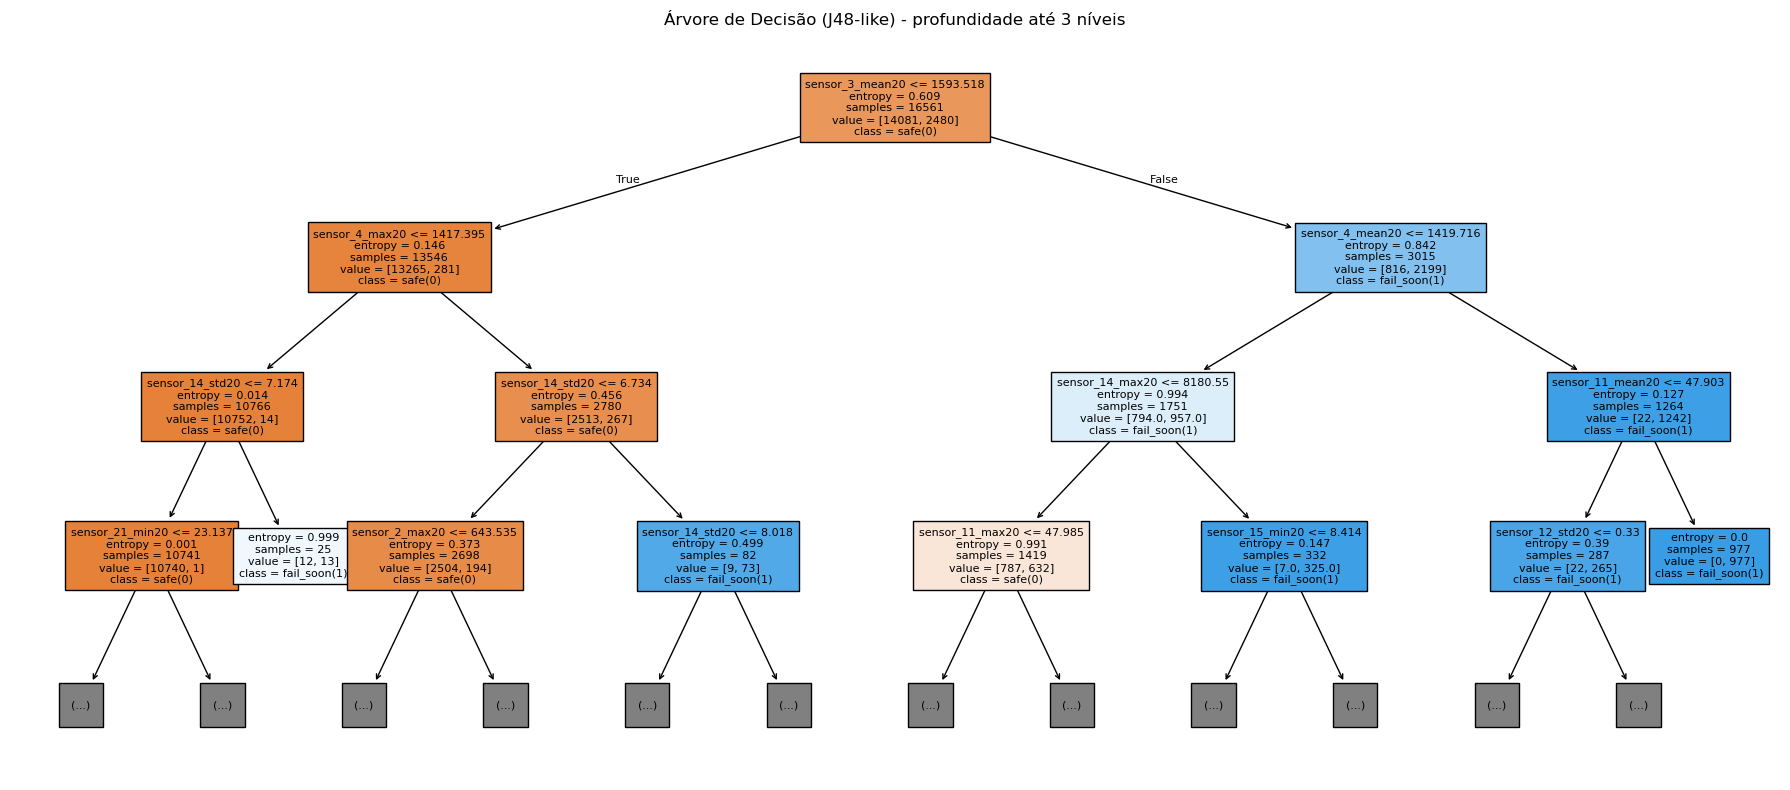

In [45]:
## 8. Plot Decision Trees
feature_names = list(X_train.columns)

plt.figure(figsize=(18, 8))
plot_tree(
    tree_j48,
    feature_names=feature_names,
    class_names=["safe(0)", "fail_soon(1)"],
    filled=True,
    max_depth=3,      
    fontsize=8,
)
plt.title("Árvore de Decisão (J48-like) - profundidade até 3 níveis")
plt.tight_layout()
plt.show()

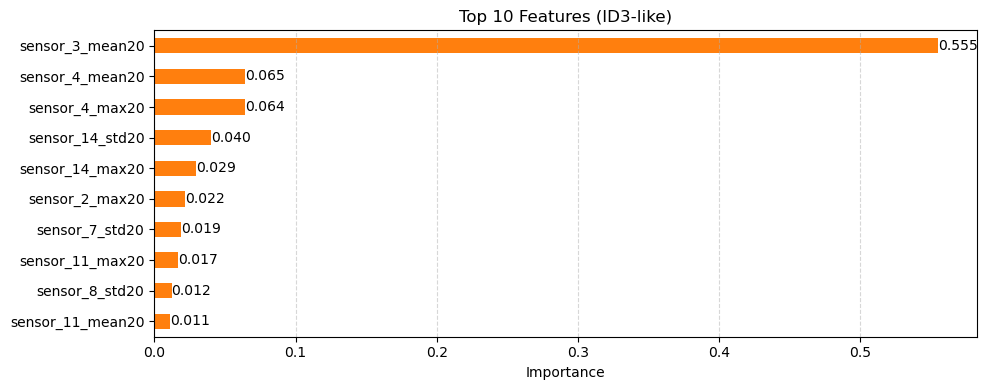

In [46]:
## 9. Feature Importance Plot for ID3-like Tree
importances_id3 = pd.Series(tree_id3.feature_importances_, index=feature_names)
importances_id3 = importances_id3.sort_values(ascending=False)

# Plot N features
top_n = 10
top = importances_id3.head(top_n)[::-1] 

plt.figure(figsize=(10, max(4, 0.35 * len(top))))
ax = top.plot(kind="barh", color="C1")
ax.set_xlabel("Importance")
ax.set_title(f"Top {len(top)} Features (ID3-like)")
ax.grid(axis="x", linestyle="--", alpha=0.5)

for i, (feat, val) in enumerate(top.items()):
    ax.text(val + 1e-6, i, f"{val:.3f}", va="center")

plt.tight_layout()
plt.show()

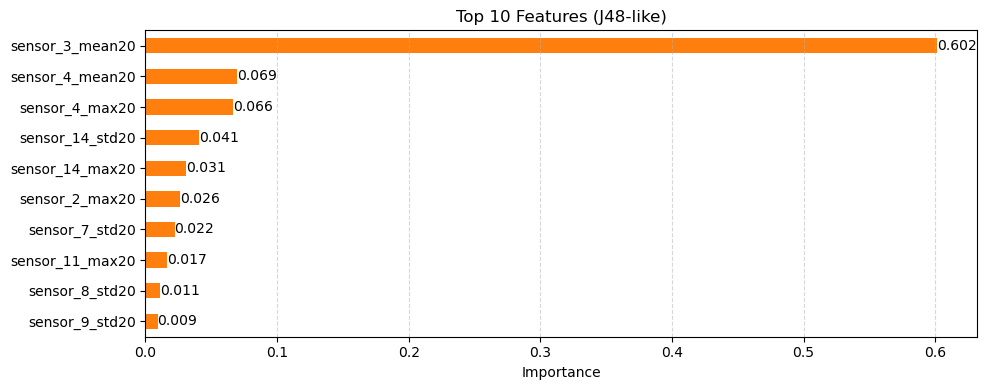

In [47]:
## 10. Feature Importance Plot for J48-like Tree
importances_j48 = pd.Series(tree_j48.feature_importances_, index=feature_names)
importances_j48 = importances_j48.sort_values(ascending=False)

# Plot N features
top_n = 10
top = importances_j48.head(top_n)[::-1]  

plt.figure(figsize=(10, max(4, 0.35 * len(top))))
ax = top.plot(kind="barh", color="C1")
ax.set_xlabel("Importance")
ax.set_title(f"Top {len(top)} Features (J48-like)")
ax.grid(axis="x", linestyle="--", alpha=0.5)

for i, (feat, val) in enumerate(top.items()):
    ax.text(val + 1e-6, i, f"{val:.3f}", va="center")

plt.tight_layout()
plt.show()